# Pipeline
 This pipeline should pipe an image through the localization model and the recognition model to first localize a sign in the image and then decide which sign it is. 

## Dependencies

At first, we have to install  and import some libraries 

to install dlib, read this guide: https://medium.com/analytics-vidhya/how-to-install-dlib-library-for-python-in-windows-10-57348ba1117f


In [326]:
# pip install dlib (will take some time)
# pip install matplotlib
# pip install opencv-python
# pip install numpy
# pip install tensorflow

In [327]:
import dlib
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import tensorflow as tf

## Import the image

To import your own images, edit the path of the example_images_folder.

In [328]:
example_images_folder = "images"

To be able to work with the data, convert .ppm into .jpg

In [329]:
__current_directory = os.getcwd()
dataset_path = os.path.join(__current_directory, example_images_folder)

for file in os.listdir(dataset_path):
        if not file.endswith(".ppm"):
            continue
        el_image = cv2.imread(os.path.join(dataset_path, file))
        cv2.imwrite(os.path.join(dataset_path, file.replace(".ppm", ".jpg")), el_image)

To use your own image in the folder, set it here

In [330]:
example_image_name = "00004.jpg"

# Localization

This is a threshold which indicates how sure the localization model needs to be 

In [331]:
confidence_threshold = 0.5

## Load the models 

In [332]:

models_directory = os.path.join(os.getcwd(), "../localization/resources", "models")
detectors = {
    model[6:-4]: dlib.simple_object_detector(os.path.join(models_directory, model))
    for model in os.listdir(models_directory)
}

## Load the image 

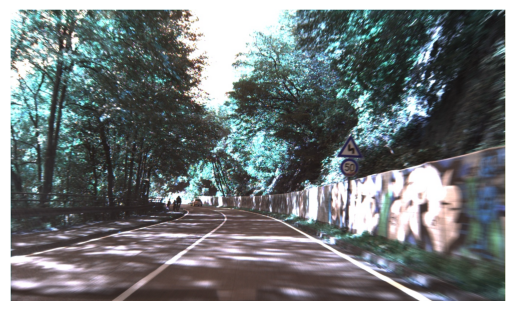

In [333]:
# The image we want to get the signs for
img = cv2.imread(os.path.join(dataset_path, example_image_name))
# We also intitialize a img_copy. We will cut the boxes out of this later 
img_copy = cv2.imread(os.path.join(dataset_path, example_image_name))
plt.imshow(img)
plt.axis("off")
plt.show()

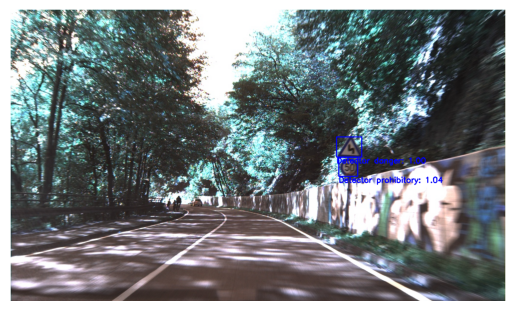

In [334]:

# apply the model to the image
boxes, confidences, detector_idxs = dlib.simple_object_detector.run_multiple(
    list(detectors.values()), img, upsample_num_times=1, adjust_threshold=0.0
)
cropped_images = []
for i in range(len(boxes)):
    if confidences[i] < confidence_threshold:
        continue  # Skip if confidence is below threshold
    
    box = boxes[i]
    cropped_images.append(img_copy[box.top():box.bottom(), box.left():box.right()])
    label = f"Detector {list(detectors.keys())[detector_idxs[i]]}: {confidences[i]:.2f}"
   
    # Draw bounding box
    cv2.rectangle(img, (box.left(), box.top()), (box.right(), box.bottom()), (0, 0, 255), 2)
    
    # Display label and confidence below the box
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7 
    font_thickness = 2 
    text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
    text_x = box.left()
    text_y = box.bottom() + text_size[1] + 5

    cv2.putText(img, label, (text_x, text_y), font, font_scale, (0, 0, 255), font_thickness)

plt.imshow(img)
plt.axis("off")
plt.show()

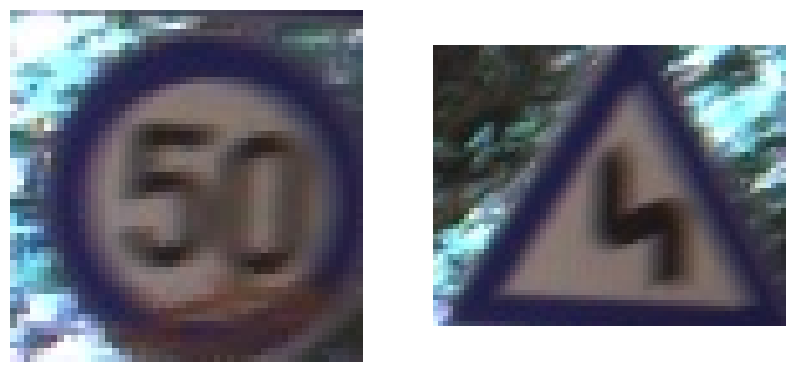

In [335]:
plt.figure(figsize=(10, 5))  
for i in range(len(cropped_images)):
    plt.subplot(1, len(cropped_images), i+1)
    plt.imshow(cropped_images[i])
    plt.axis('off')  

plt.show()

## Recognition

### Prepare the images

In [336]:
resized_images = []
for cropped_image in cropped_images:
    img = cv2.resize(cropped_image, (64, 64))
    img = np.expand_dims(img, axis=0)
    resized_images.append(img)

## Load the model

In [337]:
model = tf.keras.models.load_model('../recognition/final_model.h5', compile=False)

## Predict the sign

In [338]:
import sys
sys.path.append("../recognition/")
from constants import CLASS_ID_TO_NAME

predicted_classes = []
for image in resized_images:
    #predict
    predictions = model.predict(image)
    # choose the one with the highest probability
    predicted_class_id = np.argmax(predictions[0])
    # map the output to a class name
    predicted_classes.append(CLASS_ID_TO_NAME.get(predicted_class_id, "Unknown Class"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


## Output

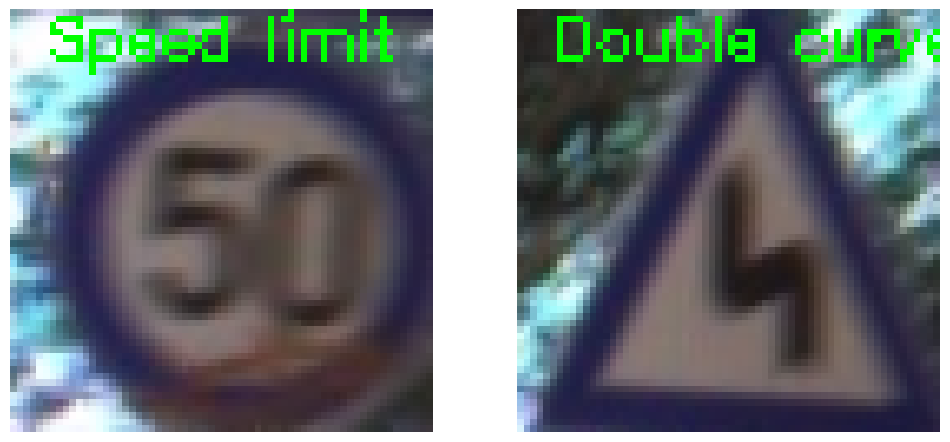

In [339]:

plt.figure(figsize=(12, 7))  
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.3
font_thickness = 1 
for i in range(len(resized_images)):
    label = predicted_classes[i]
    cv2.putText(resized_images[i].squeeze(), label, (5,7), font, font_scale, (0, 255, 0), font_thickness)
    plt.subplot(1, len(resized_images), i+1)
    plt.imshow(resized_images[i].squeeze())
    plt.axis('off')  
plt.show()